# PROJECT
4-connected grid (Manhattan distance)
input: map
output: path coordinates
References:
- Exercice 5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop 
import cv2

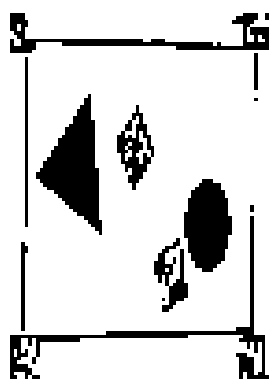

In [69]:
# Load the image
image_path = 'images/test.jpg'
image = cv2.imread(image_path)

# Determine the scale factor to resize the image
height, width = image.shape[:2]

max_dim = max(height, width)
scale_factor = 100 / max_dim  # Ensure the longest dimension is 100 (standardisé)

# Resize the image
new_width = int(width * scale_factor)
new_height = int(height * scale_factor)
resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Convert the image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to convert it to pure black and white
_, bw_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

"""# Convert the black-and-white image to RGB
bw_rgb_image = cv2.merge([bw_image, bw_image, bw_image])

# Add a green pixel at (450, 300)
if 450 < bw_rgb_image.shape[0] and 300 < bw_rgb_image.shape[1]:  # Ensure the pixel is within bounds
    bw_rgb_image[450, 300] = [0, 255, 0]  # Green pixel
    bw_rgb_image[100, 100] = [0, 0, 255]"""

# Display the modified image
plt.imshow(cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
bw_image = np.where(bw_image == 0, -1., bw_image) # conversion for next part
bw_image = np.where(bw_image == 255, 0., bw_image) # conversion for next part
#print(bw_image)
#print(bw_image.shape)

[[ 0.  0.  0. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [-1. -1. -1. ...  0. -1.  0.]
 [-1.  0.  0. ... -1. -1.  0.]
 [-1. -1.  0. ... -1. -1. -1.]]
Path found:
Number of operations: 1656


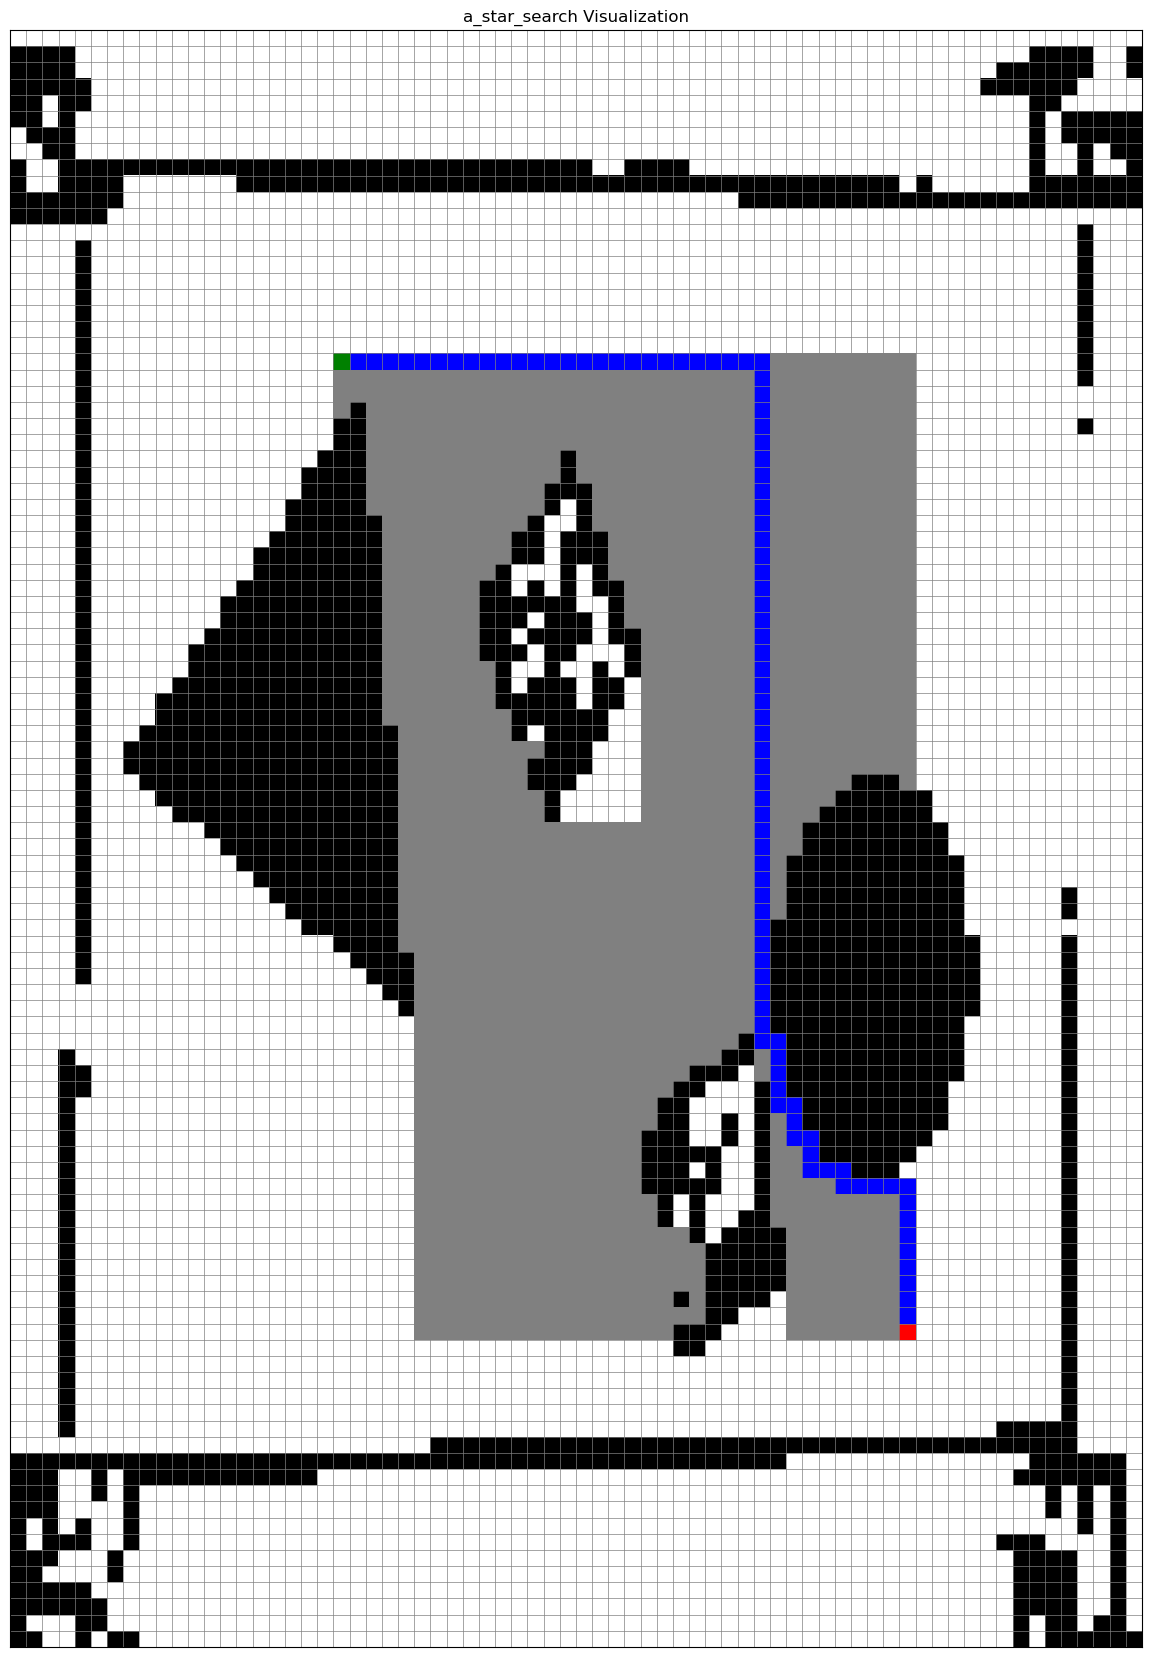

In [73]:
def heuristic(a, b):
    # Implement the Manhattan distance heuristic
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(map_grid, start, goal):
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, goal), 0, start))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_pos = heappop(open_set)

        # Add the current node to the explored set
        explored.add(current_pos)

        # For directly reconstruct path
        if current_pos == goal:
            break

        # Get the neighbors of the current node (up, down, left, right)
        neighbors = [
            (current_pos[0] - 1, current_pos[1]),  # Up
            (current_pos[0] + 1, current_pos[1]),  # Down
            (current_pos[0], current_pos[1] - 1),  # Left
            (current_pos[0], current_pos[1] + 1)#,   # Right
            #(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left
            #(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right
            #(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left
            #(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right
        ]

        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]):
                if map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                    # Determine cost for moving (diagonal or cardinal)
                    #step_cost = np.sqrt(2) if abs(neighbor[0] - current_pos[0]) == 1 and abs(neighbor[1] - current_pos[1]) == 1 else 1 #todo here
                    # Calculate tentative_g_cost
                    #tentative_g_cost = current_g_cost + step_cost + map_grid[neighbor[0], neighbor[1]] #todo here

                    
                    # Calculate tentative_g_cost
                    tentative_g_cost = current_g_cost + 1 + map_grid[neighbor[0], neighbor[1]]

                    # If this path to neighbor is better than any previous one
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        # Update came_from, g_costs, and f_cost
                        came_from[neighbor] = current_pos
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + heuristic(neighbor, goal)

                        # Add neighbor to open set
                        heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        operation_count += 1

    # Reconstruct path
    if current_pos == goal:
        path = []
        while current_pos in came_from:
            path.append(current_pos)
            current_pos = came_from[current_pos]
        path.append(start)
        return path[::-1], explored,operation_count
    else:
        # If we reach here, no path was found
        return None, explored,operation_count

def display_map(map_grid, path, start, goal, explored):
    cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
    map_display = np.zeros_like(map_grid, dtype=object)

    # Assign colors based on the map grid values
    map_display[map_grid == -1] = 'black'  # Obstacles
    map_display[map_grid == 0] = 'white'   # Free space

    for position in explored:
        if map_display[tuple(position)] == 'white':
            map_display[tuple(position)] = 'grey'  # Explored cells

    # Visualize the path
    for position in path:
        if map_display[position[0], position[1]] in ['white', 'grey']:
            map_display[position[0], position[1]] = 'blue'  # Path

    #map_display[5, 3] = 'yellow' # Weighted cell
    map_display[start[0], start[1]] = 'green'  # Start
    map_display[goal[0], goal[1]] = 'red'      # Goal

    # Convert color names to numbers for plotting
    color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
    map_numeric_display = np.vectorize(color_mapping.get)(map_display)
    fig, ax = plt.subplots(figsize=(18, 21))
    ax.imshow(map_numeric_display, cmap=cmap)
    ax.set_xticks(np.arange(-0.5, map_grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, map_grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title('a_star_search Visualization')
    plt.show()

def global_navigation(map_grid, start, goal):
    path, explored, operation_count = a_star_search(map_grid, start, goal)
    # Display the result
    if path:
        print("Path found:")
        print(f"Number of operations: {operation_count}")
        display_map(map_grid, path, start, goal, explored)
        #return path
    else:
        print("No path found.")

def main():
    ########
    # INPUT FROM VISION
    ########
    """
    with open("bw_image.txt", "w") as file:
        for row in bw_image:
            file.write(" ".join(map(str, row)) + "\n")
    """
  
    Map = bw_image
    print(Map)
    SearchStart = (20, 20) 
    SearchGoal  = (80, 55)
    
    #SearchStart = (height//10*2, width//10*2) 
    #SearchGoal  = (height//10*8, width//10*8)
    """
    Map = np.zeros((42, 59)) #A0
    #Map[5, 3] = 2; # Weighted cell
    Map[0, :] = -1; Map[41, :] = -1; Map[:, 0] = -1; Map[:, 58] = -1 # bordure
    Map[15, 39] = -1;
    Map[4:16, 3:12] = -1
    Map[1:25, 20:26] = -1
    Map[1:15, 35:39] = -1
    Map[30:36, 40:52] = -1
    Map[15:24, 45:58] = -1
    Map[20:41, 10:15] = -1
    SearchStart = (40, 1) 
    SearchGoal  = (1, 57)
    print(Map)
    """
    """
    with open("mapp.txt", "w") as file:
        for row in Map:
            file.write(" ".join(map(str, row)) + "\n")"""
    ########
    # INPUT FROM VISION
    ########
    """with open("map.txt", "w") as file:
        for row in Map:
            file.write(" ".join(map(str, row)) + "\n")"""
    
    path = global_navigation(Map, SearchStart, SearchGoal)
    #output is the path

main()